# Overfit Example

In [1]:
import matplotlib.pyplot as plt
import numpy as np


def make_fig():
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['left'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    return fig, ax

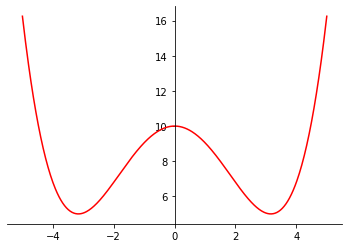

In [2]:
def func(x, a,b,c,d,e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

params_real = (0.05, 0.0, -1.0, 0.0, 10)

# Make "true" data
x = np.linspace(-5,5,500)
y = func(x, *params_real)

# Draw true data
fig, ax = make_fig()
ax.plot(x,y, 'r')

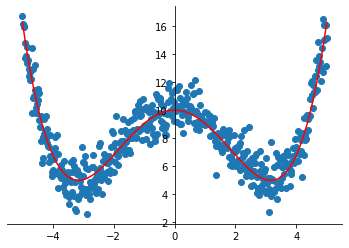

In [3]:
# Generate noise
noise = np.random.normal(0, 1, (len(y),))

# Draw noisy data
fig, ax = make_fig()
ax.plot(x, y, 'r')
ax.scatter(x=x, y=y + noise)

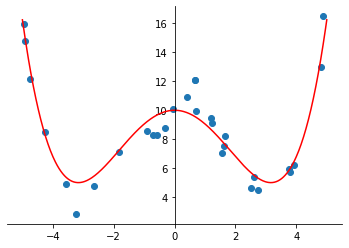

In [4]:
# Select training set from noisy data
selected = np.random.choice(range(len(y)), size=30)
train_x = x[selected]
train_y = (y + noise)[selected]


# Draw training set
fig, ax = make_fig()
ax.plot(x,y, 'r')
ax.scatter(x=train_x, y=train_y)

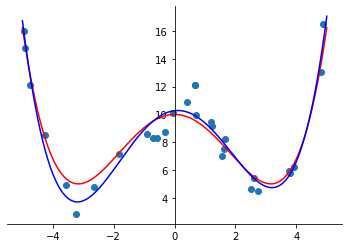

In [5]:
import scipy.optimize

def func(x, a,b,c,d,e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

params_predicted, _ = scipy.optimize.curve_fit(func, xdata=train_x, ydata=train_y, p0=(1,1,1,1,1), sigma=[1.0]*len(train_y))

y_predicted = func(x, *params_predicted)
fig, ax = make_fig()
ax.plot(x,y, 'r')
ax.scatter(x=train_x, y=train_y)
ax.plot(x,y_predicted, 'b')

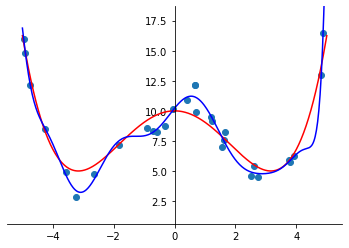

In [6]:
def overfitted(x, *coefs):
    return sum(map(lambda term: term[1]*x**term[0], enumerate(coefs)))

params_overfitted, _ = scipy.optimize.curve_fit(overfitted, xdata=train_x, ydata=train_y, p0=(1,1,1,1,1,1,1,1,1,1,1,1,1,1,1), sigma=[1.0]*len(train_y))
y_overfitted = overfitted(x, *params_overfitted)
fig, ax = make_fig()
ax.set_ylim([min(y + noise) - 2, max(y+noise)+2])
ax.plot(x,y, 'r')
ax.scatter(x=train_x, y=train_y)
ax.plot(x,y_overfitted, 'b')

## Generalize Experiment

Let's generalize this experiment

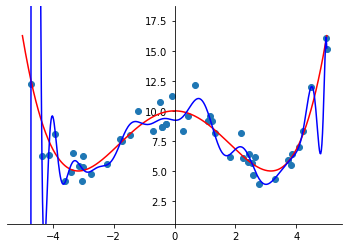

In [7]:

def polynome(x, *coefs):
    return sum(map(lambda term: term[1]*x**term[0], enumerate(coefs)))


def experiment(x, y, sigma, train_size, terms):
    selected = np.random.choice(range(len(y)), size=train_size)
    train_x = x[selected]
    train_y = y[selected]
    coefs_predicted, _ = scipy.optimize.curve_fit(polynome, xdata=train_x, ydata=train_y, p0=(1,)*terms, sigma=[sigma]*len(train_y))
    return coefs_predicted, train_x, train_y

def draw_results(x, y, noise, coefs_predicted, train_x, train_y):
    y_predicted = polynome(x, *coefs_predicted)
    fig, ax = make_fig()
    ax.set_ylim([min(y + noise) - 2, max(y+noise)+2])
    ax.plot(x, y, 'r')
    ax.scatter(x=train_x, y=train_y)
    ax.plot(x, y_predicted, 'b')
    
draw_results(x, y, noise, *experiment(x, y+noise, sigma=1.0, train_size=50, terms=25))

## Different Train-Size/Complexity levels

Now that we have a general procedure to perform an experiment, let's see how the picture changes for different numbers of terms in a polynome and different sizes of training sets.

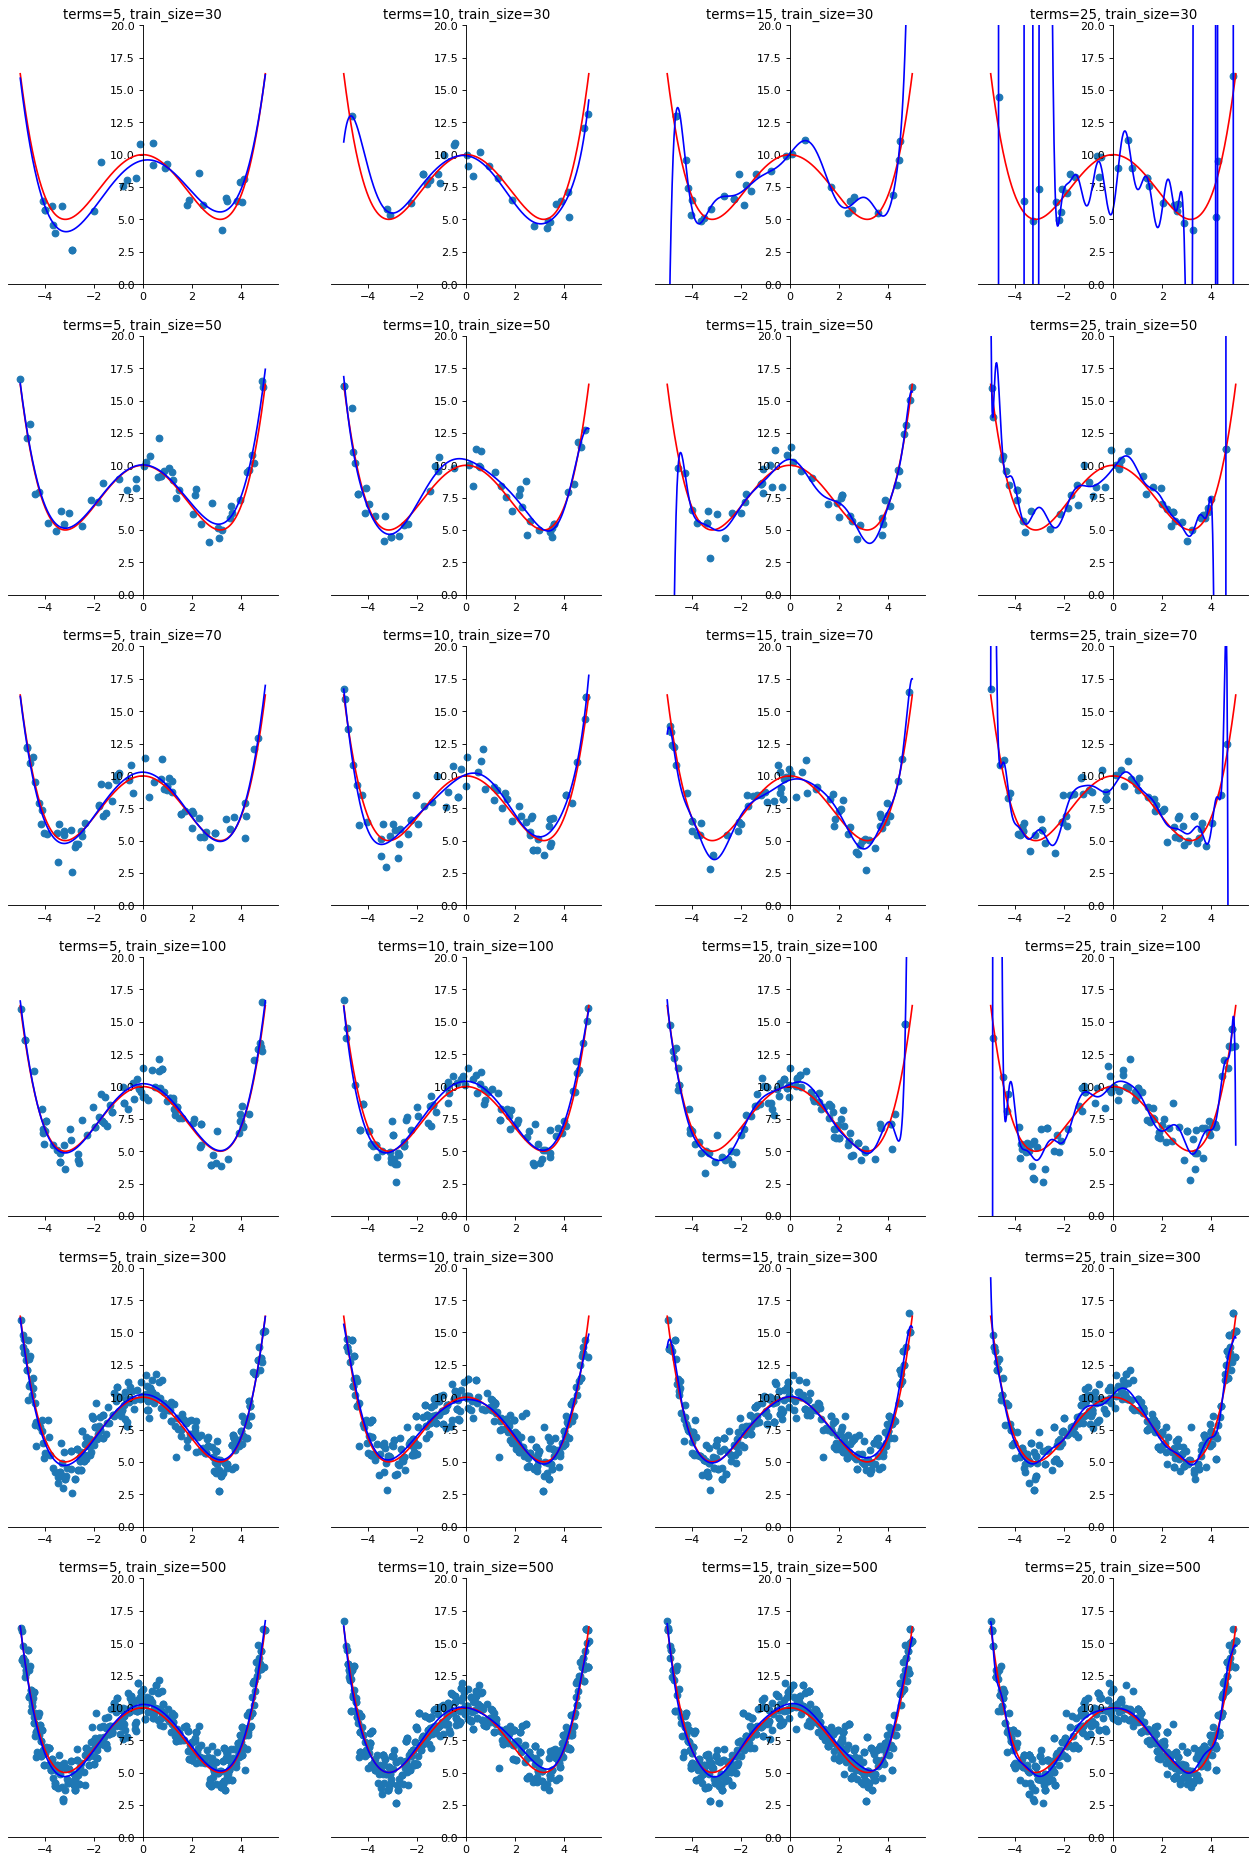

In [8]:
term_counts = [5, 10, 15, 25]
train_sizes = [30, 50, 70, 100, 300, 500]

fig = plt.figure(figsize=(20, 30), dpi=80)
for i, terms in enumerate(term_counts):
    for j, train_size in enumerate(train_sizes):
        predicted_coefs, x_train, y_train = experiment(x, y+noise, sigma=1.0, train_size=train_size, terms=terms)
        y_predicted = polynome(x, *predicted_coefs)
        
        axes = fig.add_subplot(len(train_sizes), len(term_counts), i + j*len(term_counts) + 1)
        axes.spines['left'].set_position('center')
        axes.spines['right'].set_color('none')
        axes.spines['top'].set_color('none')
        axes.set_ylim([0, 20])
        
        axes.title.set_text(f"terms={terms}, train_size={train_size}")
        
        axes.plot(x, y, 'r')
        axes.scatter(x=x_train, y=y_train)
        axes.plot(x, y_predicted, 'b')

## Measure Statistical Error 

Now let's cosider a single fit on a random training set as a single event and measure error.

(3180983.8441237886, 1.853272992249656)

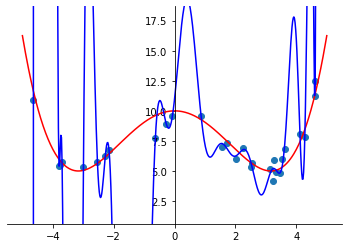

In [29]:
def select(x, y, size):
    selected = np.random.choice(range(len(y)), size=size)
    return x[selected], y[selected]

def diff(a: np.ndarray, b: np.ndarray) -> float:
    return np.average(np.absolute(a - b))

def measure_error(x, y, noise, sigma, train_size, terms):
    train_x, train_y = select(x, y + noise, train_size)
    coefs_predicted, _ = scipy.optimize.curve_fit(polynome, xdata=train_x, ydata=train_y, p0=(1,)*terms, sigma=[sigma]*len(train_y))
    train_predicted = polynome(train_x, *coefs_predicted)
    train_error = diff(train_y, train_predicted)
    y_predicted = polynome(x, *coefs_predicted)
    real_error = diff(y, y_predicted)
    return real_error, train_error

def draw(x, y, noise, sigma, train_size, terms):
    draw_results(x, y, noise, *experiment(x, y+noise, sigma=sigma, train_size=train_size, terms=terms))


draw(x, y, noise, sigma=1.0, train_size=30, terms=25)

measure_error(x, y, noise, sigma=1.0, train_size=26, terms=25)


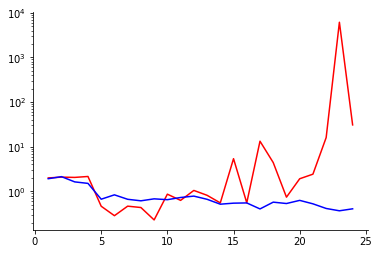

In [78]:
def prepare_experiment(x, y, noise, sigma, tries):
    def measure(train_size, terms):
        return measure_error(x, y, noise, sigma, train_size, terms)
    return measure


exp = prepare_experiment(x, y, noise, sigma=1.0, tries=1000)

terms = np.array(range(1,25))
errs = np.array([exp(41, terms) for terms in terms])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_yscale('log')
ax.plot(terms, errs[:, 0], 'r')
ax.plot(terms, errs[:, 1], 'b')